# Payments Classifier

# Main Problem Definition

Build a predictor that informs whether a payment occurs ahead of time, on time or if it's delayed. Consider that a payment is on time if it occurs within the same month of the due date.

_________________

In [1]:
# Setup
import pandas as pd
import numpy as np
import pandas_profiling as pp
import seaborn as sns
from datetime import datetime
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from model_library import baseline
from model_library import xgboost
from model_library import svc
from model_library import naive_bayes
from model_library import knn
from model_library import logistic_regression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.preprocessing import label_binarize
import joblib
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import data
df = pd.read_csv(r'./2021/training_data.csv')

In [3]:
df.head()

MANDT  BUKRS  GJAHR  HKONT  KUNNR  PRCTR KNA1_LAND1 KNA1_ORT01  ZTERM  \
0    310      3   2018     11  18724      1         NL    KATWIJK     63   
1    310      3   2018     11  19521      1         NL  WARNSVELD     63   
2    310      3   2018     11   5420      1         NL        OSS     63   
3    310      3   2018     11  18724      1         NL    KATWIJK     63   
4    310      3   2018     11   5420      1         NL        OSS     63   

  DUE_DATE_SOURCE  ...  TBSLT_LTEXT  MANSP  CTLPC HISTORICRATING  \
0           ZBD2T  ...      Invoice    NaN    NaN            NaN   
1           ZBD2T  ...      Invoice    NaN    NaN            NaN   
2           ZBD2T  ...      Invoice    NaN    NaN            NaN   
3           ZBD2T  ...      Invoice    NaN    NaN            NaN   
4           ZBD2T  ...      Invoice    NaN    NaN            NaN   

  CURRENTRATING       DATUM    DUE_DATE  GJAHR2 DOCUMENT_DATE PAYMENT_DATE  
0           NaN  2017-12-01  2017-12-23    2019  1.512086e+15     20180109  
1           NaN  2018-01-02  2018-01-10    2016  1.514851e+15     20180109  
2           NaN  2017-12-01  2017-12-27    2019  1.512086e+15     20180109  
3           NaN  2018-01-02  2018-01-27    2016  1.514851e+15     20180109  
4           NaN  2018-01-02  2018-01-07    2016  1.514851e+15     20180109  

[5 rows x 25 columns]

In [4]:
df.dtypes

MANDT                int64
BUKRS                int64
GJAHR                int64
HKONT                int64
KUNNR                int64
PRCTR                int64
KNA1_LAND1          object
KNA1_ORT01          object
ZTERM                int64
DUE_DATE_SOURCE     object
VALUE_EUR            int64
MWSTS              float64
MWST2              float64
BLART               object
T003T_LTEXT         object
TBSLT_LTEXT         object
MANSP               object
CTLPC              float64
HISTORICRATING      object
CURRENTRATING       object
DATUM               object
DUE_DATE            object
GJAHR2               int64
DOCUMENT_DATE      float64
PAYMENT_DATE         int64
dtype: object

In [5]:
# Add payment timeliness feature based on payment date and due date.
# A payment is on time if it occurs within the same month of the due date.

df['PAYMENT_DATE'] = pd.to_datetime(df['PAYMENT_DATE'], format='%Y%m%d')
df['DUE_DATE'] = pd.to_datetime(df['DUE_DATE'])
df['DOCUMENT_DATE'] = pd.to_datetime(df['DUE_DATE'])
df['DATUM'] = pd.to_datetime(df['DATUM'])

In [6]:
# On time
df.loc[df['PAYMENT_DATE'].dt.strftime('%Y-%m') == df['DUE_DATE'].dt.strftime('%Y-%m'), 'PAYMENT_TIMELINESS'] = 0

# Not on time
df.loc[df['PAYMENT_DATE'].dt.strftime('%Y-%m') > df['DUE_DATE'].dt.strftime('%Y-%m'), 'PAYMENT_TIMELINESS'] = 1

# Ahead of time
df.loc[df['PAYMENT_DATE'].dt.strftime('%Y-%m') < df['DUE_DATE'].dt.strftime('%Y-%m'), 'PAYMENT_TIMELINESS'] = 2

In [7]:
# Add date delta feature, it can be useful
df['TIME_DELTA'] = df['DUE_DATE'] - df['DATUM']
df['TIME_DELTA'] = df['TIME_DELTA'].dt.days

In [8]:
# Generate profiling report
prof = pp.ProfileReport(df)
prof.to_file(output_file='output.html')

Summarize dataset:   0%|          | 0/41 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
prof

When analyzing the profiling report, we can conclude:
- The target feature (PAYMENT_TIMELINESS) is quite unbalanced.
- When analyzing the Pearson’s correlation, it is visible that there is not much linear correlation between the payment timeliness and the other variables.
- When analyzing the Phik’s correlation – a measure suitable for categorical, ordinal and interval variables that captures non-linear dependency – it is visible that there is some correlation between the payment timeliness and the variables KNA1_LAND1, MANSP, BURKS, TBSLT_LTEXT and TIME_DELTA.

In [10]:
### DATA CLEANSING ###

# Check for missing values
print(df.isnull().sum())

MANDT                      0
BUKRS                      0
GJAHR                      0
HKONT                      0
KUNNR                      0
PRCTR                      0
KNA1_LAND1                 0
KNA1_ORT01                 0
ZTERM                      0
DUE_DATE_SOURCE            0
VALUE_EUR                  0
MWSTS                      0
MWST2                      0
BLART                      0
T003T_LTEXT                0
TBSLT_LTEXT                0
MANSP                 258474
CTLPC                 112180
HISTORICRATING        105971
CURRENTRATING         105972
DATUM                      0
DUE_DATE                   0
GJAHR2                     0
DOCUMENT_DATE              0
PAYMENT_DATE               0
PAYMENT_TIMELINESS         0
TIME_DELTA                 0
dtype: int64


The features MANSP, CTLPC, HISTORICRATING and CURRENTRATING are almost empty, therefore they were removed from the list of relevant features.

_______________________________________________

### Model

- As the correlation analysis was not conclusive to identify a final set of relevant features to model in order to predict the payments timeliness, the approach was based on using the feature importance of a model.
- The selected model was Gradient Boosting, as it performs well on unbalanced data. It is a type of machine learning model that creates an ensemble based on multiple weak leaners (decision trees). It starts by fitting an initial model to the data, then a second model is built that focuses on accurately predicting the cases where the first model performs poorly. The combination of these two models is expected to be better than either model alone. Then this process is repeated over and over again.  
- The hyperparameter tuning method was Bayesian Optimization, conscious of computing performance.
- The dataset was split in 2 sets to avoid data leakage:
    - Train – used to train the model and perform the hyperparameter tuning with cross-validation.
    - Test – used to evaluate the model. 


In [11]:
# Label encoding
def encode_features(df,s):
    le = preprocessing.LabelEncoder()
    le.fit(df[s])
    df['CD_'+s] = le.transform(df[s])
    
    return le

In [12]:
le_KNA1_ORT01 = encode_features(df,'KNA1_ORT01')
le_KNA1_LAND1 = encode_features(df,'KNA1_LAND1')
le_DUE_DATE_SOURCE = encode_features(df,'DUE_DATE_SOURCE')
le_BLART = encode_features(df,'BLART')
le_T003T_LTEXT = encode_features(df,'T003T_LTEXT')
le_TBSLT_LTEXT1 = encode_features(df,'TBSLT_LTEXT')

In [13]:
def feature_engineering(df,feature_list=list):

    # Filter dataset for relevant features
    df_model = df[feature_list]

    # Split dataset into X and y
    X = df_model.copy()
    X.pop('PAYMENT_TIMELINESS')
    y = df_model[['PAYMENT_TIMELINESS']]

    # Split dataset into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

    return df_model, X_train, X_test, y_train, y_test

In [14]:
df_model, X_train, X_test, y_train, y_test = feature_engineering(df,
        ['MANDT', 'BUKRS', 'GJAHR', 'HKONT', 'KUNNR', 'PRCTR', 
        'ZTERM', 'VALUE_EUR', 'MWSTS', 'MWST2','CTLPC', 'GJAHR2',
       'PAYMENT_TIMELINESS', 'TIME_DELTA','CD_KNA1_LAND1', 'CD_KNA1_ORT01', 
        'CD_DUE_DATE_SOURCE', 'CD_BLART','CD_T003T_LTEXT', 'CD_TBSLT_LTEXT'])

In [17]:
# Function to build models
def build_model(X,y,niter,model_list=list):
    '''model_list = [baseline, svc, naive_bayes, knn, logistic_regression, xgboost]'''
    gsearchs = []
    best_models = []
    scores = []
    best_params = []
    cv_results = []
    
    print('---------------- MODEL TRAINING ----------------')
    
    for i in model_list:
        
        string = str(i)
        model_name_ = string[string.find('.')+1:]
        model_name = model_name_[0:model_name_.find('>')-1].strip()       
        print('\nModel: ', model_name)
        
        # Get model
        model = i.model
        
        # Create pipeline
        pipe = Pipeline([('scaler', MinMaxScaler()),('model',model)])
        #pipe = Pipeline([('model',model)])
    
        # Get hyperparameter grid
        param_search = i.parameters
        
        # Stratified k-fold cross-validation
        skf = StratifiedKFold(n_splits=4)
        my_cv = [(train,test) for train, test in skf.split(X,y)]
        
        gsearch = BayesSearchCV(pipe, cv=skf, search_spaces=param_search, n_jobs=10,scoring='accuracy',
                                     verbose=True,refit=True,n_iter=niter)
        
        
        gsearch.fit(X, y)
        
        sorted_idx = gsearch.best_estimator_.named_steps["model"].feature_importances_.argsort()
        plt.barh(X.columns[sorted_idx], gsearch.best_estimator_.named_steps["model"].feature_importances_[sorted_idx])
        plt.xlabel("Xgboost Feature Importance")
        
        gsearchs.append(gsearch)
        best_models.append(gsearch.best_estimator_)
        scores.append(gsearch.best_score_)
        best_params.append(gsearch.best_params_)
        cv_results.append(gsearch.cv_results_)
        
        print('CV accuracy for model {0}: {1}'.format(model_name,gsearch.best_score_))
        
    return gsearchs,best_models,scores,best_params,cv_results

---------------- MODEL TRAINING ----------------

Model:  xgboost
Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   4 out of   4 | elapsed:  2.3min finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=10)]: Done   4 out of   4 | elapsed:  1.8min finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=10)]: Done   4 out of   4 | elapsed:  2.9min finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=10)]: Done   4 out of   4 | elapsed:  2.5min finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=10)]: Done   4 out of   4 | elapsed:  3.3min finished


CV accuracy for model xgboost: 0.8161227717885148


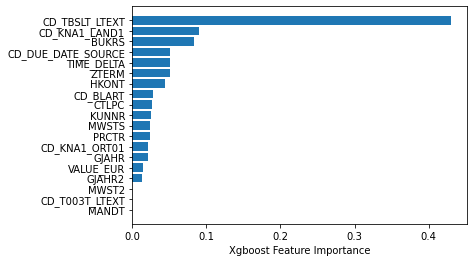

In [18]:
# Train models using cross-validation with hyperparameter tuning
gsearchs,best_models,scores,best_params,cv_results = build_model(X_train,y_train,5,model_list=[xgboost])

In [20]:
# Function to evaluate models
def evaluate_model(X_test, X_train,y_train, y_test, best_models):
    
    acc_results = []
    f1_results = []
    
    print('---------------- MODEL EVALUATION ----------------')
    
    model_counter = 1
    for i in best_models:
        
        string = str(i)
        model_name_ = string[string.find(''''model',''')+len(''''model', '''):]
        model_name = model_name_[0:model_name_.find('(')].strip() 
        print('\nModel #{0}: {1}'.format(model_counter,model_name))
        
        # Predict
        y_pred = i.predict(X_test)        
        df_pred = pd.DataFrame(data=y_pred, columns=['PAYMENT_TIMELINESS_HAT'],index=y_test.index)
        
        # Evaluation metrics
        accuracy = metrics.accuracy_score(y_test, y_pred)
        f1 = metrics.f1_score(y_test, y_pred, average=None)  
        precision = precision_score(y_test, y_pred, average=None)
        recall = recall_score(y_test, y_pred, average=None)
        
        
        # Labels to binarize
        labels = [0, 1, 2]

        # Binarize ytest with shape (n_samples, n_classes)
        ytest = label_binarize(y_test, classes=labels)

        # Binarize ypreds with shape (n_samples, n_classes)
        ypreds = label_binarize(y_pred, classes=labels)
        
        # Get roc auc result
        roc_auc = roc_auc_score(ytest, ypreds, average=None,multi_class='ovo')
        
        acc_results.append(accuracy)
        f1_results.append(f1)
        
        print('Accuracy: ',accuracy)
        print('Average F1 Score: ',f1.mean())
        print('F1 Score by Class: ',f1)
        print('Average Precision: ',precision.mean())
        print('Precision by Class: ',precision)
        print('Average Recall: ',recall)
        print('Recall by Class: ',recall.mean())
        print('ROC AUC score by Class: ',roc_auc)
        print('Average ROC AUC score: ',roc_auc.mean())
        print('\nConfusion Matrix:\n',confusion_matrix(y_test, y_pred))
        print('\nClassification Report:\n',classification_report(y_test, y_pred))
        
        model_counter+=1
    
    # Get best model based on accuracy score
    maxi_model_nb = acc_results.index(max(acc_results))
    
    maxi_model = best_models[maxi_model_nb]
    string_ = str(maxi_model)
    maxi_model_name_ = string_[string_.find(''''model',''')+len(''''model', '''):]
    maxi_model_name = maxi_model_name_[0:maxi_model_name_.find('(')].strip() 
    
    
    print('\nBest Model: #{0} {1}'.format(maxi_model_nb+1,maxi_model_name))
    
    
    return acc_results,f1_results, maxi_model

In [21]:
acc_results,f1_results,maxi_model = evaluate_model(X_test, X_train,y_train, y_test, best_models)

---------------- MODEL EVALUATION ----------------

Model #1: XGBClassifier
Accuracy:  0.822470988828279
Average F1 Score:  0.7420453086305637
F1 Score by Class:  [0.88400728 0.6361114  0.70601725]
Average Precision:  0.7886169024703596
Precision by Class:  [0.84388645 0.7364956  0.78546866]
Average Recall:  [0.92813346 0.55980948 0.64116262]
Recall by Class:  0.7097018547204467
ROC AUC score by Class:  [0.77707795 0.75658428 0.80798475]
Average ROC AUC score:  0.7805489933439742

Confusion Matrix:
 [[55856  2902  1423]
 [ 6790  9285   511]
 [ 3543   420  7081]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      0.93      0.88     60181
         1.0       0.74      0.56      0.64     16586
         2.0       0.79      0.64      0.71     11044

    accuracy                           0.82     87811
   macro avg       0.79      0.71      0.74     87811
weighted avg       0.82      0.82      0.81     87811


Best Model: #1 XGBClassi

The final list of features to include in the model was defined using the feature importance of the gradient boosting model that included all features of the dataset.

In [22]:
df_model, X_train, X_test, y_train, y_test = feature_engineering(df,
        ['BUKRS', 'GJAHR', 'HKONT', 'KUNNR', 'PRCTR', 
        'ZTERM', 'VALUE_EUR', 'MWSTS', 'CTLPC',
       'PAYMENT_TIMELINESS', 'TIME_DELTA','CD_KNA1_LAND1', 'CD_KNA1_ORT01', 
        'CD_DUE_DATE_SOURCE', 'CD_BLART', 'CD_TBSLT_LTEXT'])

---------------- MODEL TRAINING ----------------

Model:  xgboost
Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   4 out of   4 | elapsed:  1.0min finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=10)]: Done   4 out of   4 | elapsed:  1.3min finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=10)]: Done   4 out of   4 | elapsed:   39.7s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=10)]: Done   4 out of   4 | elapsed:   42.5s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=10)]: Done   4 out of   4 | elapsed:   18.7s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=10)]: Done   4 out of   4 | elapsed:  1.4min finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=10)]: Done   4 out of   4 | elapsed:   20.7s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=10)]: Done   4 out of   4 | elapsed:  4.2min finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=10)]: Done   4 out of   4 | elapsed:  2.5min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   4 out of   4 | elapsed:  1.9min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   4 out of   4 | elapsed:  3.4min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   4 out of   4 | elapsed:   50.5s finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   4 out of   4 | elapsed:   42.9s finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   4 out of   4 | elapsed:   29.3s finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   4 out of   4 | elapsed:   19.8s finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   4 out of   4 | elapsed:    2.9s finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   4 out of   4 | elapsed:  7.1min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   4 out of   4 | elapsed:   57.9s finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   4 out of   4 | elapsed:  3.6min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   4 out of   4 | elapsed:  3.6min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   4 out of   4 | elapsed:  2.0min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   4 out of   4 | elapsed:   22.6s finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   4 out of   4 | elapsed:  2.4min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   4 out of   4 | elapsed:  3.1min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   4 out of   4 | elapsed:  4.3min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   4 out of   4 | elapsed:   39.0s finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   4 out of   4 | elapsed:    2.7s finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   4 out of   4 | elapsed:  4.4min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   4 out of   4 | elapsed:  2.9min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   4 out of   4 | elapsed:  7.7min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   4 out of   4 | elapsed:  5.7min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   4 out of   4 | elapsed:  1.5min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   4 out of   4 | elapsed:   19.8s finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   4 out of   4 | elapsed:  4.5min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   4 out of   4 | elapsed:  1.8min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   4 out of   4 | elapsed:  2.6min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   4 out of   4 | elapsed:   18.4s finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   4 out of   4 | elapsed:   36.2s finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   4 out of   4 | elapsed:  9.2min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   4 out of   4 | elapsed:  6.4min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   4 out of   4 | elapsed:   45.1s finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   4 out of   4 | elapsed:  6.5min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   4 out of   4 | elapsed:  6.3min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   4 out of   4 | elapsed:  3.0min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   4 out of   4 | elapsed:   37.4s finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   4 out of   4 | elapsed:   34.5s finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   4 out of   4 | elapsed:  3.2min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   4 out of   4 | elapsed:   14.7s finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   4 out of   4 | elapsed:  2.0min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   4 out of   4 | elapsed:  6.2min finished


CV accuracy for model xgboost: 0.8214906720813094


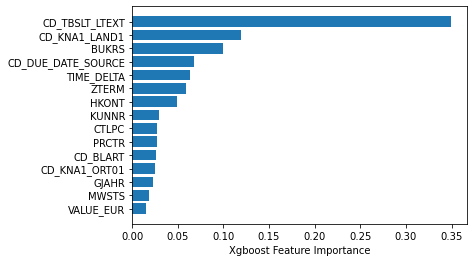

In [23]:
# Train models using cross-validation with hyperparameter tuning
gsearchs,best_models,scores,best_params,cv_results = build_model(X_train,y_train,50,model_list=[xgboost])

In [24]:
acc_results,f1_results,maxi_model = evaluate_model(X_test, X_train,y_train, y_test, best_models)

---------------- MODEL EVALUATION ----------------

Model #1: XGBClassifier
Accuracy:  0.8285180672125361
Average F1 Score:  0.749508919723742
F1 Score by Class:  [0.88814394 0.64446295 0.71591988]
Average Precision:  0.800914456085426
Precision by Class:  [0.84535572 0.75894754 0.79844011]
Average Recall:  [0.93549459 0.55999035 0.64885911]
Recall by Class:  0.714781351214896
ROC AUC score by Class:  [0.78137379 0.75928616 0.81264715]
Average ROC AUC score:  0.7844356975176611

Confusion Matrix:
 [[56299  2545  1337]
 [ 6826  9288   472]
 [ 3473   405  7166]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      0.94      0.89     60181
         1.0       0.76      0.56      0.64     16586
         2.0       0.80      0.65      0.72     11044

    accuracy                           0.83     87811
   macro avg       0.80      0.71      0.75     87811
weighted avg       0.82      0.83      0.82     87811


Best Model: #1 XGBClassifi

The overall accuracy results are reasonably good, achieving more than 80% of accuracy.
However, as this is a multi-class problem, it is important to check the other evaluation metrics by label.
The class imbalance causes significant drops on the precision, recall and F1 score for both labels 1 and 2.
The ROC AUC numbers are quite uniform for all labels, enough to deem the model as acceptable.
In order to improve the classifier, the class imbalance should be addressed, adopting for instance resampling techniques of under-sampling or over-sampling.

In [25]:
# Save best model to disk
filename = 'final_model.sav'
joblib.dump(maxi_model, filename)

['final_model.sav']

In [26]:
# Load the best model from disk (optional)
loaded_model = joblib.load(filename)
print(loaded_model)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 XGBClassifier(learning_rate=0.37655505670737344, max_depth=15,
                               min_samples_leaf=12, min_samples_split=72,
                               missing=nan, n_estimators=58,
                               objective='multi:softprob', random_state=16,
                               subsample=0.9818415200280183))])
